# Milestone 2
## Anggito Krisnandhana Zainul

## Dataset
**The dataset contains Magnetic Resonance Imaging (MRI) results of subjects with healthy brains and subjects that suffers from brain tumors. The tumors in this dataset is further classified into three different types: Glioma, Meningioma, and Pituitary Tumor.**

## Objective
**Create a Convolutional Neural Network (CNN) model that is able to detect tumors from MRI scan result and accurately classify them.**

# A. Library Import

In [2]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import EfficientNetB0

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
import pathlib

# B. Data Loading

In [3]:
# State dataset file location
combined_folder=r'Dataset'
train_folder=r'Training'
test_folder=r'Testing'

data_dir = pathlib.Path(train_folder)
image_count = len(list(data_dir.glob('*/*.jpg')))
print('The amount of image in the training dataset:', image_count)

The amount of image in the training dataset: 2870


# C. Exploratory Data Analysis

## Training Data Composition

In [4]:
def convert_image_to_dataset(file_location):
    label=0
    df=pd.DataFrame()
    for category in glob(file_location+'/*'):
        for file in tqdm(glob(category+'/*')):
            img_array=cv2.imread(file)
            img_array=cv2.resize(img_array,(224, 224))
            data=pd.DataFrame({'image':[img_array],'label':[label]})
            df=df.append(data)
        label+=1
    return df.sample(frac=1).reset_index(drop=True)

In [5]:
train_data=convert_image_to_dataset(train_folder)
train_x=np.array(train_data.image.to_list())

100%|██████████| 827/827 [00:06<00:00, 118.94it/s]


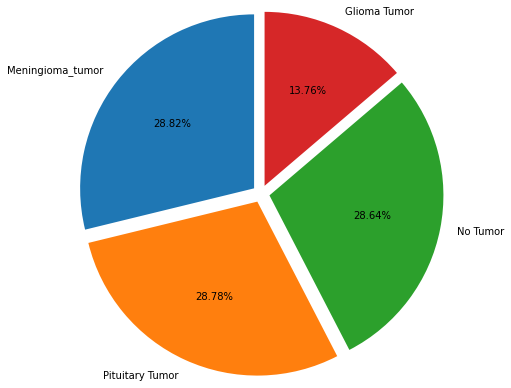

In [6]:
plt.pie(train_data.label.value_counts(), startangle=90, explode=[0.1,0.1,0.1,0.1], autopct='%0.2f%%',
        labels=['Meningioma_tumor', 'Pituitary Tumor', 'No Tumor', 'Glioma Tumor'], radius=2)
plt.show()

### EDA Analysis

**The pie chart aboves visualizes how the training dataset consists of 28.64% sample of normal brain scans, 28.78% of Piutitary tumor brain scans, 28.82% of Meningioma tumor brain scans, and 13.76% of Glioma tumor brain scans.**
**The data is clearly unbalanced between the normal brain scans and tumor brain scans, furthermore the percentage of each type of brain tumor in the dataset is also unbalanced.**

## Image Sample in the Dataset

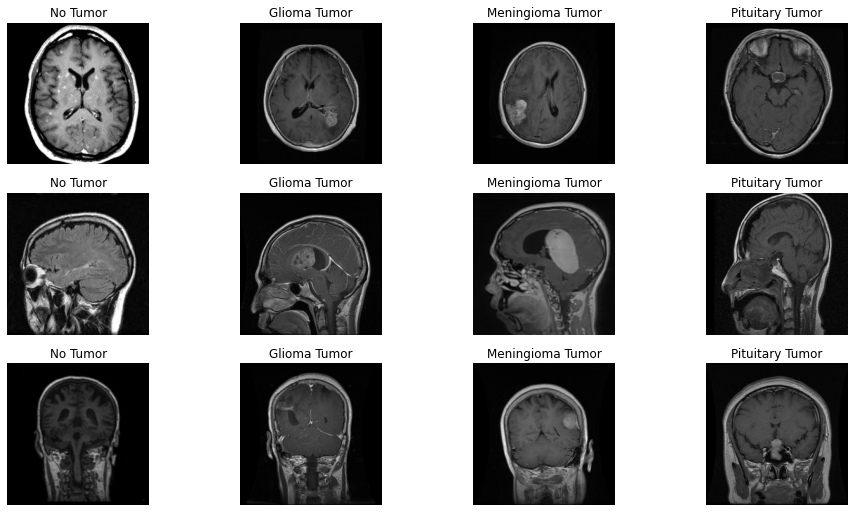

In [7]:
plt.figure(figsize=(16, 12))

path = 'Training/'
fileNames = [
    'no_tumor/4.jpg', 'glioma_tumor/gg (10).jpg', 'meningioma_tumor/m (108).jpg', 'pituitary_tumor/p (12).jpg',
    'no_tumor/image (5).jpg', 'glioma_tumor/gg (57).jpg', 'meningioma_tumor/m1(13).jpg', 'pituitary_tumor/p (139).jpg',
    'no_tumor/image(226).jpg', 'glioma_tumor/gg (313).jpg', 'meningioma_tumor/m (75).jpg', 'pituitary_tumor/p (244).jpg'
    ]

fileLabels = [
    'No Tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor', 
    'No Tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor',
    'No Tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor',
    ]

for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    img = mpimg.imread(path + fileNames[i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.title(fileLabels[i])
    plt.axis("off")

### EDA Analysis

* **The MRI results in this dataset are greyscale images. Tumor in the brain will show as a light coloration in some part inside of the brain area. The visualization above illustrates how tumors can varies in terms of size. Larger tumor might be easily identified by human eye, but the existence of smaller and less noticeable tumors reinforced the need for a ML model to help physician identify tumors in their patients.**
* **There are multiple angles of the MRI results in this dataset, mainly 3: top-angle, side-angle, and back-angle. This can be a positive thing because the model will be trained using a variety of of MRI results and not constricted to learning a single angle of MRI scan results. However it should be noted that the sample amount of the different angles are not the same and it's possible that the model will be more trained in classifying tumors from a certain angle.**
* **There are 3 different types of tumors in this dataset: Glioma, Meningioma, and Pituitary. The visualization above shows how the difference between the three can be subtle, thus ML model can help physician to make a more accurate diagnosis for their patients.**


# Data Preprocessing

## Create Train and Test Dataset with Tensorflow Pipeline

In [8]:
IMG_WIDTH=150
IMG_HEIGHT=150
batch_size=20

# Train Dataset Pipeline
train_dataset = image_dataset_from_directory(
    train_folder,
    shuffle=True,
    subset='training',
    validation_split=0.2,
    seed=1337,
    batch_size=batch_size,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
    )

# Test Dataset Pipeline
test_dataset = image_dataset_from_directory(
    train_folder,
    shuffle=True,
    subset='validation',
    validation_split=0.2,
    seed=1337,
    batch_size=batch_size,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
    )

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.


In [9]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

class_names = train_dataset.class_names
print(class_names)

(20, 150, 150, 3)
(20,)
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


# Model Definition

In [10]:
num_classes = 4

model = Sequential([
    
    layers.Conv2D(64, (5,5), padding='Same', activation='relu', input_shape = (150, 150, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), padding='Same', activation='relu'),
    layers.MaxPooling2D((2,2), strides=(2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), padding='Same', activation='relu'),
    layers.MaxPooling2D((2,2), strides=(2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3,3), padding='Same', activation='relu'),
    layers.MaxPooling2D((2,2), strides=(2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3,3), padding='Same', activation='relu'),
    layers.MaxPooling2D((2,2), strides=(2,2)),
    layers.Dropout(0.3),

    layers.Flatten(),

    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 128)       0

# Model Evaluation

In [11]:
epochs=20

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs
)

Epoch 1/20
115/115 [==============================] - 73s 373ms/step - loss: 4.2977 - accuracy: 0.3863 - val_loss: 1.1939 - val_accuracy: 0.5174
Epoch 2/20
115/115 [==============================] - 37s 318ms/step - loss: 1.1072 - accuracy: 0.5013 - val_loss: 1.0182 - val_accuracy: 0.5662
Epoch 3/20
115/115 [==============================] - 38s 324ms/step - loss: 1.0050 - accuracy: 0.5706 - val_loss: 0.8799 - val_accuracy: 0.6202
Epoch 4/20
115/115 [==============================] - 37s 317ms/step - loss: 0.8973 - accuracy: 0.6237 - val_loss: 0.9807 - val_accuracy: 0.5401
Epoch 5/20
115/115 [==============================] - 37s 317ms/step - loss: 0.8382 - accuracy: 0.6389 - val_loss: 0.7455 - val_accuracy: 0.6585
Epoch 6/20
115/115 [==============================] - 37s 321ms/step - loss: 0.7722 - accuracy: 0.6668 - val_loss: 0.7306 - val_accuracy: 0.6638
Epoch 7/20
115/115 [==============================] - 37s 317ms/step - loss: 0.7092 - accuracy: 0.7056 - val_loss: 0.7451 - val_ac

## Accuracy and Loss Graph

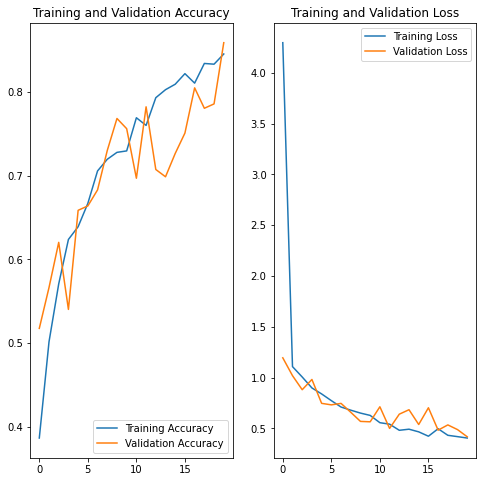

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis

* **The accuracy of the model continuously increased for each iterations both when using the training and validation dataset. By the last iteration, the model managed to generate an accuracy of around 80-85% for both dataset. Additionally, the performance between using the two dataset are close to each other, indicating that the model is neither under or over fitted.**

* **The loss of the model continuously decreased for each iterations both when using the training and validation dataset. By the last iteration, the model have a loss of around 0.3-0.4. The loss function is an additional proof that the model is neither under or over fitted.**

## Confusion Matrix
**(0:glioma_tumor), (1:meningioma_tumor), (2:no_tumor), (3:pituitary_tumor)**

              precision    recall  f1-score   support

           0       0.32      0.29      0.30       171
           1       0.19      0.24      0.21       129
           2       0.08      0.08      0.08        92
           3       0.26      0.24      0.25       182

    accuracy                           0.23       574
   macro avg       0.21      0.21      0.21       574
weighted avg       0.23      0.23      0.23       574



<AxesSubplot:>

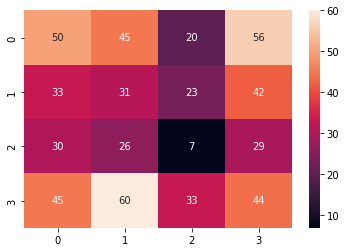

In [13]:
y_pred = model.predict(test_dataset)

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = tf.concat([y for x, y in test_dataset], axis=0)

print(classification_report(predicted_categories, true_categories))

sns.heatmap(confusion_matrix(predicted_categories, true_categories), annot=True)

# Model Improvement

## Model Definition and Fitting

**In this section, I want to try the transfer learning method by adapting the EfficientNetB0 model into the model to classify the tumor using the dataset in this project. The EfficientNetB0 model is chosen because it was found to be the most accurate model used on CIFAR 10 dataset, which is an image dataset with multiple class similar to the dataset in this project.**

In [14]:
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

model2 = effnet.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(rate=0.2)(model2)
model2 = tf.keras.layers.Dense(4, activation='softmax')(model2)
model2 = tf.keras.models.Model(inputs=effnet.input, outputs = model2)

model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

In [18]:
epochs = 8

history2 = model2.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=epochs
  )

Epoch 1/8
115/115 [==============================] - 106s 917ms/step - loss: 0.0384 - accuracy: 0.9904 - val_loss: 0.2171 - val_accuracy: 0.9460
Epoch 2/8
115/115 [==============================] - 107s 928ms/step - loss: 0.0156 - accuracy: 0.9961 - val_loss: 0.2185 - val_accuracy: 0.9408
Epoch 3/8
115/115 [==============================] - 106s 925ms/step - loss: 0.0291 - accuracy: 0.9887 - val_loss: 0.2247 - val_accuracy: 0.9582
Epoch 4/8
115/115 [==============================] - 109s 946ms/step - loss: 0.0251 - accuracy: 0.9913 - val_loss: 0.1761 - val_accuracy: 0.9512
Epoch 5/8
115/115 [==============================] - 106s 924ms/step - loss: 0.0230 - accuracy: 0.9930 - val_loss: 0.3478 - val_accuracy: 0.9268
Epoch 6/8
115/115 [==============================] - 100s 870ms/step - loss: 0.0272 - accuracy: 0.9917 - val_loss: 0.2332 - val_accuracy: 0.9443
Epoch 7/8
115/115 [==============================] - 103s 897ms/step - loss: 0.0351 - accuracy: 0.9900 - val_loss: 0.2146 - val_ac

## Accuracy and Loss Graph

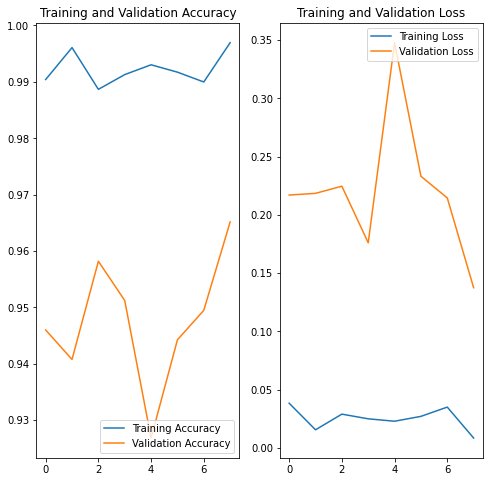

In [19]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analysis

* **The model's accuracy using the training dataset continuously increased through each iteration, however it is unstable when using the validation dataset. However, the by the end of the iteration the model generated an accuracy around 99% using the training dataset and 92% using the validation dataset. This is higher than the performance of the previous model and the model managed to achieve this result through shorter iterations. There is also a distance between the perfomance result while using the training and validation dataset, thus indicating that the model is overfitted to the training data.**

* **A similar thing happened to the loss function of the model where it decreased through each iterations using the training dataset and unstable using the validation dataset. This reinforced the fact that this model is overfitted to the training data.**

## Confusion Matrix
**(0:glioma_tumor), (1:meningioma_tumor), (2:no_tumor), (3:pituitary_tumor)**

<AxesSubplot:>

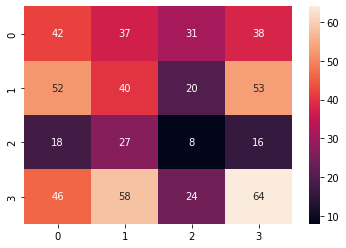

In [58]:
y_pred2 = model2.predict(test_dataset)

predicted_categories2 = tf.argmax(y_pred2, axis=1)

sns.heatmap(confusion_matrix(predicted_categories2, true_categories), annot=True)

# Model Inference

class_names = train_dataset.class_names
print(class_names)

## First Model

### No Tumor

In [20]:
test_image1 = r'Testing/no_tumor/no_test (22).jpg'

img = keras.preprocessing.image.load_img(
    test_image1, target_size=(IMG_HEIGHT, IMG_WIDTH)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to no_tumor with a 47.37 percent confidence.


### Glioma Tumor

In [21]:
test_image2 = r'Testing/glioma_tumor/glioma_test (22).jpg'

img = keras.preprocessing.image.load_img(
    test_image2, target_size=(IMG_HEIGHT, IMG_WIDTH)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to no_tumor with a 33.67 percent confidence.


### Meningioma Tumor

In [22]:
test_image3 = r'Testing/meningioma_tumor/meningioma_test (22).jpg'

img = keras.preprocessing.image.load_img(
    test_image3, target_size=(IMG_HEIGHT, IMG_WIDTH)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to meningioma_tumor with a 36.83 percent confidence.


### Pituitary Tumor

In [23]:
test_image4 = r'Testing/pituitary_tumor/pituitary_test (22).jpg'

img = keras.preprocessing.image.load_img(
    test_image4, target_size=(IMG_HEIGHT, IMG_WIDTH)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to pituitary_tumor with a 42.95 percent confidence.


## Second Model

### No Tumor

In [28]:
test_image1 = r'Testing/no_tumor/no_test (22).jpg'

img = keras.preprocessing.image.load_img(
    test_image1, target_size=(IMG_HEIGHT, IMG_WIDTH)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to no_tumor with a 47.46 percent confidence.


### Glioma Tumor

In [29]:
test_image2 = r'Testing/glioma_tumor/glioma_test (22).jpg'

img = keras.preprocessing.image.load_img(
    test_image2, target_size=(IMG_HEIGHT, IMG_WIDTH)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to no_tumor with a 46.83 percent confidence.


### Meningioma Tumor

In [30]:
test_image3 = r'Testing/meningioma_tumor/meningioma_test (22).jpg'

img = keras.preprocessing.image.load_img(
    test_image3, target_size=(IMG_HEIGHT, IMG_WIDTH)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to meningioma_tumor with a 47.54 percent confidence.


### Pituitary Tumor

In [27]:
test_image4 = r'Testing/pituitary_tumor/pituitary_test (22).jpg'

img = keras.preprocessing.image.load_img(
    test_image4, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to pituitary_tumor with a 47.54 percent confidence.


# Conclusion and Analysis

* **The first model managed to achieve an accuracy around 85% and, based on the evaluation, is neither under or overfitted.**

* **The second model, created using transfer learning method and adapting EfficientNetB0 model, perfomed better than the first in terms of accuracy. It achieved an accuracy of around 90% and also a lower loss function that is closer to zero compared to the first model. However, the second model is found to be somewhat overfitted to the training data.**

* **From the Model Inference, both model managed to accurately classified the MRI results except when it comes to the Glioma tumor sample. This can either be the result of Glioma tumors are generally too subtle for the model to classify or the particular Glioma sample for the model inference is a difficult one to discern.**

* **The main utility of the model is to help physician to identify tumor based on analyzing MRI results. From the result of this project, I conclude that it is possible for a ML model to identify and classify tumors. However, considering that the model can still make mistakes (for example, in the model inference), ML in this field should only be supplementary and not be relied on exclusively.**

# Model Saving and Loading

In [31]:
# Model Saving
model.save("tumor_ann.h5")
